In [2]:
import os # Handle OS file systems and directory paths
import random # Random number
import numpy as np # Import NumPy for arrays and such
import matplotlib.pyplot as plt # Plotting Tools
import numpy.linalg as npl # Linear Algebra Library
import time # Time
# from google.colab import drive # Read files in from Google Drive
import pandas as pd # Import Pandas for data processing
import datetime as dt
import scipy.io as sio
import io
from decimal import Decimal # String to double conversion
from glob import glob  # 从 glob 模块中导入 glob 函数

In [3]:
import boto3
from botocore.exceptions import NoCredentialsError

In [4]:
# Optionally, you can specify the AWS region
s3 = boto3.client('s3', region_name='us-east-1')  # Replace 'us-west-2' with your AWS region

In [5]:
import pandas as pd
s3_uri = 's3://pepper-dataset/crop_data/crop_IOWA/Iowa_corn_2019.csv'
df = pd.read_csv(s3_uri)

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/fsspec/registry.py:275: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


In [6]:
df.shape

(425, 21)

In [61]:
# get county list
# county_path_list = glob('/content/drive/MyDrive/ai/era5/county_env/*')
# county_list = [os.path.basename(x) for x in county_path_list]
# print(county_list)

#Read files from s3
bucket_name = 'pepper-dataset'
prefix = 'county-env-data/county_env_IOWA/processed_with_all_features_ver_2/'

# List to store all object keys
county_files = []

# Initial call to list_objects_v2
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

# Process the initial response
while True:
    # Collect keys from current response
    current_keys = [obj['Key'] for obj in response.get('Contents', [])]
    county_files.extend(current_keys)

    # Check if there are more objects to retrieve
    if not response['IsTruncated']:
        break  # No more objects to retrieve

    # Get ContinuationToken for next paginated call
    continuation_token = response['NextContinuationToken']

    # Make subsequent call with ContinuationToken
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix, ContinuationToken=continuation_token)
    
    
county_files = ["/" + path if not path.startswith("/") else path for path in county_files]

In [62]:
len(county_files)

54648

In [63]:
county_files[:10]

['/county-env-data/county_env_IOWA/processed_with_all_features_ver_2/Iowa_Adair/Iowa_Adair_2000-01_part1.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_features_ver_2/Iowa_Adair/Iowa_Adair_2000-01_part2.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_features_ver_2/Iowa_Adair/Iowa_Adair_2000-02_part1.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_features_ver_2/Iowa_Adair/Iowa_Adair_2000-02_part2.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_features_ver_2/Iowa_Adair/Iowa_Adair_2000-03_part1.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_features_ver_2/Iowa_Adair/Iowa_Adair_2000-03_part2.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_features_ver_2/Iowa_Adair/Iowa_Adair_2000-04_part1.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_features_ver_2/Iowa_Adair/Iowa_Adair_2000-04_part2.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_features_ver_2/Iowa_Adair/Iowa_Adair_2000-05_part1.csv',
 

In [ ]:
# try 1 county
year_range = [2015, 2020]
years = [x for x in range(year_range[0], year_range[-1]+1)]

filtered_files = [file_path for file_path in county_files
                  if any(str(year) in file_path for year in years)]

# basedir = '/content/drive/MyDrive/ai/era5/county_env/'
# county_files = []

# for c in county_list:
#   county = os.path.join(basedir, c)
#   print(county)

#   county_f = glob(os.path.join(county, '*'))

#   for f in county_f:
#     ym_str = f.split('_')[-2]
#     ym_obj = dt.datetime.strptime(ym_str, '%Y-%m')
#     if ym_obj.year not in years:
#         continue
#     county_files.append(f)

print(len(filtered_files))

  # print(len(county_files))
  # print(county_files[:3])

# get year-month info for the county
# ym_list = [x.split('_')[-2] for x in county_files]
# ym_list = list(set(ym_list))
# ym_list.sort()
# print(ym_list)

filtered_files


In [ ]:
pd.read_csv('s3://'+bucket_name+filtered_files[0])

In [69]:
df_list = pd.DataFrame(columns=("Year","State","County","Month","Commodity","Feature"))

for csvf in filtered_files:
    # only read part1, then match with part2
    if 'part2' in csvf:
        continue
    # print(csvf)
    crop = "UNKNOWN"

    suffix = csvf.split('/')[-1]
    state = suffix.split('_')[-4].upper()
    county_name = suffix.split('_')[-3].upper()
    ym_str = csvf.split('_')[-2]

    year = int(suffix.split('-')[0][-4:])
    month = int(suffix.split('-')[1][:2])
    ym_obj = dt.datetime.strptime(ym_str, '%Y-%m')
    if ym_obj.year not in years:
        continue
    # else:
    #     print(ym_str)
        # pass

    df1 = pd.read_csv('s3://'+bucket_name+csvf)
    # df1.dropna(axis=1)
    csvf_part2 = csvf.replace('part1', 'part2')
    df2 = pd.read_csv('s3://'+bucket_name+csvf_part2)
    # df2.dropna(axis=1)


    df12 = pd.merge(df1, df2, on = 'datetime')
      # drop datetime
    df12 = df12.drop(columns=['datetime'])
    df12 = df12.drop(columns=['sshf'])
    df12 = df12.drop(columns=['evavt'])
    # df12.drop(columns=['datetime'])
    # print(df12.head())
    # print("size:", len(df12))
    # print(df12.dtype)

    # print("-----------------------")
    # print(df12.shape)
    row = [year,state,county_name,month,crop]
    row.append(df12)
    # print(row[:4])

    # df_list.append(df12)
    dfLength = len(df_list)
    df_list.loc[dfLength] = row

# df_all = df_list[0]
# for df in df_list[1:]:
#     df_all = pd.concat([df_all, df], axis = 0)

print("Number of Features Per County Per Year:  >= ",len(df_list.iloc[1,4]))
# print(df_list["State"])
# df_list['Feature'] = df_list['Feature'].astype(object)

# df_list.to_csv('/content/drive/MyDrive/ai/era5/dataSat_cleaned_Iowa_2015-2020.csv', index=False)


KeyboardInterrupt



In [ ]:
df_list.iloc[1][-1].head()

,t2m,rsn,sde,stl1,stl2,stl3,stl4,tsn,swvl1,swvl2,swvl3,swvl4,evabs,sp,ssrd,strd,tp
0,258.530131,155.129382,0.190767,271.884039,272.731070,274.348786,278.176249,259.682203,0.355494,0.357537,0.377132,0.381440,-2.168404e-19,97336.216848,9.545403e+06,1.718303e+07,1.439836e-04
1,257.821265,155.168526,0.190667,271.885309,272.728227,274.346295,278.172617,258.669374,0.355402,0.357509,0.377105,0.381439,-2.168404e-19,97387.979564,0.000000e+00,7.322264e+05,8.371140e-08
2,257.035991,155.207025,0.190667,271.885360,272.725349,274.344363,278.169320,257.724867,0.355305,0.357480,0.377084,0.381439,-2.168404e-19,97437.443095,0.000000e+00,1.440454e+06,2.511342e-07
3,256.341656,155.242727,0.190667,271.885156,272.722844,274.342151,278.165688,256.937044,0.355210,0.357451,0.377057,0.381439,-2.168404e-19,97415.321214,0.000000e+00,2.139197e+06,2.511342e-07
4,255.872548,155.275419,0.190667,271.883989,272.720644,274.339968,278.162223,256.399108,0.355120,0.357421,0.377033,0.381437,-2.168404e-19,97403.483522,0.000000e+00,2.840345e+06,2.511342e-07


In [ ]:
# sys.getsizeof(df_list) / 1024 / 1024  # Byte -> MB
print(df_list.shape)
grouped_data = df_list.groupby(['Year', 'State', 'County']).size().reset_index(name='Count')
print(grouped_data)

In [ ]:
# read crop yield (cy) data
year_range = [2015, 2020]
years = [x for x in range(year_range[0], year_range[-1]+1)]

def is_convertible_to_int(s):
    try:
        int(s)
        return True
    except ValueError:
        return False

cy_file_list = glob('/content/drive/MyDrive/ai/crop_yield/*csv')
print((cy_file_list))

cy_df_list = []
for cy_file in cy_file_list:
    suffix = cy_file.split('/')[-1]
    year = suffix.split('.')[0].split('_')[-1]
    print(year)
    if is_convertible_to_int(year) and int(year) not in years:
      continue

    crop_type = cy_file.split('_')[-2]
    df = pd.read_csv(cy_file)
    # Drop Rows that do not have "YIELD" in the "DATA ITEM" column
    dataYield = df.drop(df[~df["Data Item"].str.contains("YIELD")].index, inplace = False)
    # Drop Rows that have "IRRIGATED" in the "DATA ITEM" column
    dataYield = dataYield.drop(dataYield[dataYield["Data Item"].str.contains("IRRIGATED")].index, inplace = False)
    cy_df_list.append(dataYield)

cy_df_all = cy_df_list[0]
for df in cy_df_list[1:]:
    cy_df_all = pd.concat([cy_df_all, df], axis = 0)
print(cy_df_all.shape)

print(cy_df_all.head())



['/content/drive/MyDrive/ai/crop_yield/Iowa_corn_2019.csv', '/content/drive/MyDrive/ai/crop_yield/Iowa_corn_2020.csv', '/content/drive/MyDrive/ai/crop_yield/Iowa_soybean_2020.csv', '/content/drive/MyDrive/ai/crop_yield/Iowa_soybean_2019.csv', '/content/drive/MyDrive/ai/crop_yield/Iowa_corn_2021.csv', '/content/drive/MyDrive/ai/crop_yield/Iowa_corn_2022.csv', '/content/drive/MyDrive/ai/crop_yield/Iowa_corn_2018.csv', '/content/drive/MyDrive/ai/crop_yield/Iowa_corn_2017.csv', '/content/drive/MyDrive/ai/crop_yield/Iowa_corn_2016.csv', '/content/drive/MyDrive/ai/crop_yield/Iowa_soybean_2022.csv', '/content/drive/MyDrive/ai/crop_yield/Iowa_soybean_2021.csv', '/content/drive/MyDrive/ai/crop_yield/Iowa_soybean_2018.csv', '/content/drive/MyDrive/ai/crop_yield/Iowa_soybean_2017.csv', '/content/drive/MyDrive/ai/crop_yield/Iowa_soybean_2016.csv', '/content/drive/MyDrive/ai/crop_yield/Idaho_corn_2022.csv', '/content/drive/MyDrive/ai/crop_yield/Idaho_corn_2021.csv', '/content/drive/MyDrive/ai/crop_

In [ ]:
dataROI = cy_df_all[["Year","State","County","Commodity","Value"]]
name_year = dataROI["Year"].drop_duplicates()
name_states = dataROI["State"].drop_duplicates()
name_county = dataROI["County"].drop_duplicates()
name_crops = dataROI["Commodity"].drop_duplicates()

dfOut = pd.DataFrame(columns=("Year","State","County","Commodity","Yield"))

# For each year
idx = 0
for year in name_year:
  temp_year = dataROI.loc[dataROI["Year"]==year]
  # if debug and verbose: print(temp_year)
  # For each state
  for state in name_states:
    temp_state = temp_year.loc[temp_year["State"]==state]
    # if debug and verbose: print(temp_state)
    # For each county
    for county in name_county:
      temp_county = temp_state.loc[temp_state["County"]==county]
      # if debug and verbose: print(temp_county)
      # For each crop
      for crop in name_crops:
        temp_crops = temp_county.loc[temp_county["Commodity"]==crop]
        # if debug and verbose: print(temp_crops)
        crop_yield = temp_crops["Value"]
        crop_yield = crop_yield.replace(',','', regex=True)
        crop_yield = pd.to_numeric(crop_yield)
        crop_yield = crop_yield.sum()
        # if debug and verbose: print(crop_yield)

        # Add to Output Data Frame
        dfOut.loc[idx] = [year,state,county,crop,crop_yield]

        # Increment idx
        idx = idx + 1

print(dfOut.head())
# wheat_rows = dfOut[dfOut['Commodity'] == 'WHEAT']
# print("wheat_rows: ", len(wheat_rows))
dfOut

In [ ]:
# df_list = pd.read_csv('/content/drive/MyDrive/ai/era5/dataSat_Iowa_2015-2020.csv')


In [ ]:
def runCorrelateFeatureLabel(dataLabel,dataFeature,crop="WHEAT",dropZeroYield=True,debug=False,verbose=False):
  """Takes 2 pandas DataFrames (Label & Feature) and pairs them together"""

  # Drop Rows without the Desired Crop
  # print("pre dataCrop:", dataLabel.head())
  dataCrop = dataLabel.drop(dataLabel[~dataLabel["Commodity"].str.contains("CORN")].index, inplace = False)
  print("pre2 dataCrop:", dataCrop.head())
  dataCrop = dataCrop.drop(columns=["Commodity"]) #TODO: Assume we are only using 1 commodity
  dataFeat = dataFeature.drop(columns=["Commodity"])
  print("dataCrop:", dataCrop.head())
  print("dataFeat:", dataFeat.head())
  # print("++++++++++++++++++")

  # Merge DataFrames
  # Ref: https://realpython.com/pandas-merge-join-and-concat/
  # dataCrop.index = dataCrop.index.astype('object')
  print("------1: ", dataCrop.dtypes)
  print("------2: ", dataFeat.dtypes)
  dataFeat['Year'] = dataFeat['Year'].astype('int64')
  dataMerge = dataCrop.merge(dataFeat,how='right',on=['Year','State','County'])
  print(dataMerge.head())

  # Drop Rows without yield information
  if dropZeroYield:
    dataOut = dataMerge.drop(dataMerge[dataMerge["Yield"]==0.0].index,inplace=False)
  else:
    dataOut = dataMerge

  # Drop Rows with NaN
  dataOut.dropna(subset=['Yield'],inplace=True)

  if debug: print(dataOut)

  return dataOut

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# print("row shape:", df_list.iloc[1][4].info())
print(dfOut.shape)
print(dfOut.head())
print(df_list.shape)
print(df_list.head())
print(df_list.iloc[1][5].shape)
print("---------------------+")
# print(df_list.iloc[1])
dataSet = runCorrelateFeatureLabel(dfOut,df_list,crop="CORN",dropZeroYield=True,debug=False)

print("------------------")
print(dataSet.shape)
print(dataSet.head())



(41768, 5)
   Year State  County Commodity  Yield
0  2019  IOWA   BOONE      CORN  217.8
1  2019  IOWA   BOONE  SOYBEANS   53.2
2  2019  IOWA  DALLAS      CORN  195.0
3  2019  IOWA  DALLAS  SOYBEANS   54.4
4  2019  IOWA  GRUNDY      CORN  209.8
(7128, 6)
   Year State County  Month Commodity  \
0  2019  IOWA  ADAIR      1   UNKNOWN   
1  2019  IOWA  ADAIR      2   UNKNOWN   
2  2019  IOWA  ADAIR      3   UNKNOWN   
3  2019  IOWA  ADAIR      4   UNKNOWN   
4  2019  IOWA  ADAIR      5   UNKNOWN   

                                             Feature  
0              t2m         rsn           sde     ...  
1              t2m         rsn           sde     ...  
2              t2m         rsn       sde        s...  
3              t2m         rsn           sde     ...  
4              t2m         rsn           sde     ...  
(672, 17)
---------------------+
pre2 dataCrop:    Year State    County Commodity  Yield
0  2019  IOWA     BOONE      CORN  217.8
2  2019  IOWA    DALLAS      CORN  195

In [ ]:
def saveCorrelatedData(data,savePath,saveName,debug=False):
  """Save the correlated data to a mat for easier processing"""

  # Extract from DataFrame as list
  feature = data['Feature']
  print("feature len: ", len(feature))
  label = data['Yield']
  print("label len: ", len(label))
  # print(label)
  month = data['Month']
  if debug: print(len(feature))

  feat_lst = []
  label_lst = []
  firstTimeLoop = True
  for idx in range(len(feature)):
    # if debug: print(idx)
    print("idx:", idx)
    if int(month.iloc[idx]) == 1:
      feat_new = []
    for f in feature.iloc[idx]:
      # print(f)
      # feat_new.append(feature.iloc[idx][f])
      for item in feature.iloc[idx][f]:
        feat_new.append(item)
    # feat_new = np.array(feat_new)

    # Drop Bad Datasets
    # if len(feat_new) != 20: #4320: for whole year, 2520 for Jan-Jul, 3240 for Nov-Jul
    #   if debug: print("skipping feature of length",len(feat_new))
    #   continue

    if int(month.iloc[idx]) != 12:
      continue

    if len(feat_new) != 148920:  # 检查 feat_new 列表的长度是否为 240
        print("Skipping feature at index", idx, "due to incorrect length:", len(feat_new))
        continue

    print("feat_new len:", len(feat_new))
    # print("feat_arr:", len(feat_arr))
    # Append Features
    feat_lst.append(feat_new)
    label_lst.append(label.iloc[idx])

  print(len(label_lst))
  # feat_arr = np.array(feat_lst)
  feat_arr = feat_lst
  # print(feat_arr[0])

  data_feature_expanded = pd.DataFrame(feat_arr)

  # 将 DataFrame 写入 CSV 文件
  data_feature_expanded.to_csv('/content/drive/MyDrive/ai/era5/data_feature_expanded_CORN_cleaned.csv', index=False)

  print("Data successfully written to 'data_feature_expanded.csv'")

  # Get Ready to Save
  # feature = feat_arr.tolist()
  label = label_lst
  data_label_expanded = pd.DataFrame(label)
  data_label_expanded.to_csv('/content/drive/MyDrive/ai/era5/data_label_expanded_CORN_cleaned.csv', index=False)
  print("Data successfully written to 'data_label_expanded.csv'")

  # Save Path
  # saveFile = savePath + saveName
  # print("Saving to:",saveFile)
  # sio.savemat(saveFile, mdict={'feature': feat_arr, 'label': label})

  # df = pd.DataFrame(feat_arr)
  # df['label'] = label
  # filename = '/content/drive/MyDrive/ai/era5/yield_Iowa_corn_noIrr.csv'

  # 将 DataFrame 写入 CSV 文件
  # df.to_csv(filename, index=False, header=False)
  print("++++++++++++")
  # print("feat_arr shape: ", feat_arr.shape)
  # print(feat_arr.head())
  print(len(feat_arr))
  print(len(feat_arr[0]))
  print(label)


  return label, feat_arr


# print(dataSet.iloc[1][4].shape())

label, feat_arr = saveCorrelatedData(dataSet,"/content/drive/MyDrive/ai/era5/","yield_Iowa_corn_noIrr.mat",debug=True)


In [ ]:
feat_arr[0]

[271.8417422593134,
 270.73166764484773,
 269.5343139962773,
 268.46032188461743,
 267.6394449457856,
 267.1054955913516,
 266.5843304349316,
 265.5307094051537,
 265.0833222139077,
 264.5150227947164,
 263.93166908627506,
 263.3719721180839,
 262.829719008865,
 262.1412242326452,
 261.75566715796214,
 261.6205967294126,
 262.073718887992,
 262.8907725152682,
 263.77574966189906,
 264.50271651064696,
 264.93110662260113,
 265.1228695928108,
 265.0585901672825,
 264.64806208900205,
 264.3242753916387,
 263.88071151194833,
 263.4901960800916,
 263.0919145466376,
 262.7791796092397,
 262.55671066809936,
 262.30831489547273,
 262.07342019177673,
 262.0326182887695,
 261.9903229046859,
 262.0973158889991,
 262.2085503595693,
 262.6362833398499,
 263.0407777545817,
 263.18648176839514,
 264.29273307130524,
 265.9904028804693,
 267.7920189725505,
 269.50080028092293,
 271.78182379852825,
 272.84751215540336,
 273.5748971788525,
 273.33516359646904,
 271.7667695092781,
 270.7444518428617,
 270

In [ ]:
# Helper Functions
def get_time_now_ms():
    """Returns the current time in milliseconds"""
    ts = time.time()
    ts = round(ts) * 1000
    return int(ts)

In [ ]:
!pip install keras

In [ ]:
import tensorflow as tf
from keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D
from keras.models import Model
import keras
from keras.layers import Dense, TimeDistributed
from keras.models import Sequential
# from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
# from keras.utils import np_utils
import itertools

from keras.layers import LSTM, RepeatVector
# from keras.layers.convolutional import Conv1D,Conv2D
# from keras.layers.convolutional import MaxPooling1D,MaxPooling2D
from keras.layers import Dropout, Flatten
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from numpy import dstack,  hstack
import scipy.io as sio
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn.model_selection import train_test_split


# data_mat = "/content/drive/MyDrive/ai/era5/yield_Iowa_corn_noIrr.mat" #Name of File, may need to specify path
# data_dict = sio.loadmat(data_mat) #Load MAT as a python dictionary
# print(data_dict)


In [ ]:
# data_feature = data_dict['feature'] #Extract Features
# data_feature = feat_arr
data_feature = pd.read_csv("/content/drive/MyDrive/ai/era5/data_feature_expanded_CORN_cleaned.csv")

# print('Data Feature Shape:',data_feature.shape) # Verify Shape
# print("feature len: ", len(data_feature[0][0]))
# data_label = data_dict['label'] #Extract Labels
# data_label = label
data_label = pd.read_csv("/content/drive/MyDrive/ai/era5/data_label_expanded_CORN_cleaned.csv")
# print('Data Label Shape:',data_label.shape) # Verify Shape

# print(data_label)
# c1 = ["dewpoint_temperature_2m", "temperature_2m", "soil_temperature_level_1","soil_temperature_level_2"
#       ,"soil_temperature_level_3","soil_temperature_level_4","snowfall","volumetric_soil_water_layer_1",
#       "volumetric_soil_water_layer_2","volumetric_soil_water_layer_3","volumetric_soil_water_layer_4",
#       "surface_net_solar_radiation","surface_net_solar_radiation1",
#       "total_evaporation","surface_pressure","total_precipitation"]

# c = ["dewpoint_temperature_2m", "temperature_2m", "soil_temperature_level_1","soil_temperature_level_2"
#                              ,"soil_temperature_level_3","soil_temperature_level_4","snowfall","volumetric_soil_water_layer_1",
#                               "volumetric_soil_water_layer_2","volumetric_soil_water_layer_3","volumetric_soil_water_layer_4",
#                               "surface_net_solar_radiation","surface_net_solar_radiation1",
#                               "total_evaporation","surface_pressure","total_precipitation"]*288



# 假设 data_feature 是一个 1*467 的 DataFrame，每个单元格是一个长度为 175200 的序列
# 构造一个示例 DataFrame（实际使用中应替换为你的 data_feature）
# data_feature = pd.DataFrame([[np.random.rand(175200) for _ in range(467)]])

# 将 DataFrame 转置
# data_feature_transposed = data_feature.T

# print("data_feature_transposed[0].tolist(): ", len(data_feature_transposed[0][0]))
# 展开每个单元格中的序列
# data_feature_expanded = pd.DataFrame(data_feature_transposed[0][0].tolist())

# 检查转换后的 DataFrame 形状
# print("Original shape:", data_feature.shape)
# print("Transformed shape:", data_feature_expanded.shape)


train_X = data_feature
train_y = data_label.T

train_X = np.nan_to_num(train_X)
train_y = np.nan_to_num(train_y)

print(train_X.shape)
print(train_y.shape)

x = np.asarray(train_X, dtype=np.float32)
y = np.asarray(train_y).flatten()

# Training/Validation split 67%, 33% split
data_feature, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
print(X_test.shape)
print(data_feature.shape)

(273, 148920)
(1, 273)
(91, 148920)
(182, 148920)


In [ ]:
print(data_feature.shape)
print(data_label.shape)

(182, 148920)
(273, 1)


In [ ]:
def dataReshape(dataIn,debug=True,runOnce=False):
  """Takes the 1D feature array and reshapes to 270x16"""
  print(dataIn.shape)

  dataOut = []
  for idx in range(len(dataIn)):
    dataTemp = dataIn[idx].reshape(7446, 20) #(216,15) 3240
    if debug: print(dataTemp.shape)
    dataOut.append(dataTemp)

    if runOnce: return -1

  return np.array(dataOut)

data_feature_rs = dataReshape(data_feature,debug=False,runOnce=False)
print(data_feature_rs.shape)

#Reshape test
X_test = dataReshape(X_test,debug=False,runOnce=False)
print(X_test.shape)

(182, 148920)
(182, 7446, 20)
(91, 7446, 20)
(91, 7446, 20)


In [ ]:
# Network Parameters
BATCH_SIZE = 32
NUM_EPOCHS = 200
SHUFFLE_BUFFER_SIZE = 64

# Normalize Data
normalizer = Normalization(axis=-1)
normalizer.adapt(data_feature_rs)
data_feature_norm = normalizer(data_feature_rs)

# Normalize Test
normalizer = Normalization(axis=-1)
normalizer.adapt(X_test)
X_test_norm = normalizer(X_test)


# Split into train and test datasets
# Load the Data into a data loader
train_dataset = tf.data.Dataset.from_tensor_slices((data_feature_norm,y_train.T))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_norm,y_test.T)) #TODO: REPLACE WITH TEST DATASET
DATASET_SIZE = len(data_feature_norm)

# Shuffle & Batch the Datasets
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
def step_decay(epoch):
   initial_lrate = 0.1
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,
           math.floor((1+epoch)/epochs_drop))
   return lrate

In [ ]:
# Build Network
visible = Input(shape= (7446, 20))# (270, 16))

filters1 = 80
filters2 = 64

''' 1 Dimensional Convolution Network'''
# #cnn = Dense(50, activation='relu')#(cnn)
# cnn = Conv1D(filters=filters1, kernel_size=7, activation='relu')(visible)
# # cnn = Conv1D(filters=filters1, kernel_size=7, activation='relu')(cnn)
# # cnn = Dropout(0.2)(cnn)
# cnn = MaxPooling1D(pool_size=2)(cnn)
# # cnn = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn)
# # cnn = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn)
# # cnn = MaxPooling1D(pool_size=2)(cnn)
# cnn = Flatten()(cnn)
# cnn = Dense(16, activation='relu')(cnn)
# # cnn = LSTM(50)(cnn) #TODO: this is not quite right
# # define output 1
# output1 = Dense(1)(cnn)

# ##test
# cnn = Conv1D(filters=filters1, kernel_size=7, activation='relu')(visible)
# cnn = MaxPooling1D(pool_size=2)(cnn)
# cnn = Flatten()(cnn)
# cnn = Dense(16, activation='relu')(cnn)
# output1 = Dense(1)(cnn)


# model  = Sequential()
# model.add(Conv1D(filters=filters1, kernel_size=2, activation='relu'))
# model.add(Dense(16))
# model.add(Conv1D(filters=filters1-10, kernel_size=2, activation='relu'))
# model.add(Dense(16))
# model.add(Conv1D(filters=filters1-10, kernel_size=2, activation='relu'))
# model.add(Dense(16))
# model.add(Conv1D(filters=filters1-10, kernel_size=2,activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dense(16))
# model.add(LSTM(64,recurrent_dropout=0.1))
# model.add(Dense(4))
# model.add(Flatten())
# model.add(Dense(1,activation='linear'))


cnn1 = Conv1D(filters=80, kernel_size=2, activation='relu')(visible)
cnn1 = Dense(64)(cnn1)

cnn1 = MaxPooling1D(pool_size=128)(cnn1)

cnn2 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible)
cnn2 = Dense(64)(cnn2)

cnn2 = MaxPooling1D(pool_size=128)(cnn2)

cnn3 = Conv1D(filters=32, kernel_size=2, activation='relu')(visible)
cnn3 = Dense(64)(cnn3)
cnn3 = MaxPooling1D(pool_size=128)(cnn3)

cnn4 =Conv1D(filters=16, kernel_size=2,activation='relu')(visible)
cnn4 = Dense(64)(cnn4)
cnn4 = MaxPooling1D(pool_size=128)(cnn4)
merged = keras.layers.concatenate([cnn1, cnn2,  cnn3, cnn4], axis=2)
cnn = Dense(16)(merged)
# cnn = LSTM(128,recurrent_dropout=0.1)(cnn)
# cnn =Dense(4)(cnn)
cnn = Flatten()(cnn)
output1 =Dense(1,activation='linear')(cnn)


''' 1 Dimensional Convolution Network + LSTM'''
# cnn = Conv1D(filters=10, kernel_size=2, activation='relu')(visible)
# cnn = MaxPooling1D(pool_size=2)(cnn)
# # cnn = Flatten()(cnn)
# # cnn = Dense(50, activation='relu')(cnn)
# cnn = LSTM(32)(cnn) #TODO: this is not quite right
# output1 = Dense(1)(cnn)

# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.003,
#     decay_steps=1000,
#     decay_rate=0.9)
# lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)
# optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# tie together
model = Model(inputs=visible, outputs=output1)

model.compile(optimizer='adam', loss='mse', metrics =['accuracy','mean_squared_error','mean_absolute_percentage_error',tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 7446, 20)]           0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 7445, 80)             3280      ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 7445, 64)             2624      ['input_1[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 7445, 32)             1312      ['input_1[0][0]']             
                                                                                              

Epoch 1/200
6/6 - 19s - loss: 34337.7930 - accuracy: 0.0000e+00 - mean_squared_error: 34337.7930 - mean_absolute_percentage_error: 93.4858 - root_mean_squared_error: 185.3046 - val_loss: 27662.0391 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 27662.0391 - val_mean_absolute_percentage_error: 84.0120 - val_root_mean_squared_error: 166.3191 - 19s/epoch - 3s/step
Epoch 2/200
6/6 - 10s - loss: 22553.7109 - accuracy: 0.0000e+00 - mean_squared_error: 22553.7109 - mean_absolute_percentage_error: 75.0469 - root_mean_squared_error: 150.1789 - val_loss: 13409.5469 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 13409.5469 - val_mean_absolute_percentage_error: 57.7942 - val_root_mean_squared_error: 115.7996 - 10s/epoch - 2s/step
Epoch 3/200
6/6 - 9s - loss: 7821.0815 - accuracy: 0.0000e+00 - mean_squared_error: 7821.0815 - mean_absolute_percentage_error: 41.5994 - root_mean_squared_error: 88.4369 - val_loss: 865.8311 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 865.8311 - val_

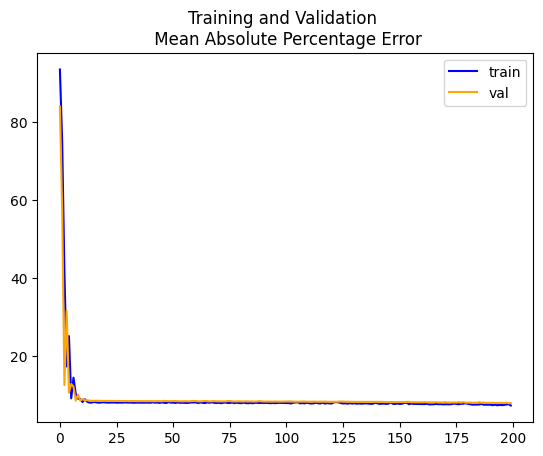

In [ ]:
# FIT model with TRAINING DATA
history = model.fit(train_dataset, validation_data=test_dataset,epochs=NUM_EPOCHS,verbose=2)
model.summary()

# EVALUATE model with TESTING DATA
model.evaluate(test_dataset, verbose=0)

ynew = model.predict(test_dataset)
print(f'Test Loss: {ynew[0]}')
print(f'Test Mean Squared Error: {ynew[1]}')
print(f'Test Mean Absolute Percentage Error: {ynew[2]}')
print(f'Test Root Mean Squared Error: {ynew[3]}')

fig, ax = plt.subplots()
ax.set_title('Training and Validation \n Mean Absolute Percentage Error') # loss = 100 * abs(y_true - y_pred) / y_true
ax.plot(history.history['mean_absolute_percentage_error'], color = 'blue', label = 'train')

# plt.title('Validation Mean Absolute Percentage Error (MAPE)') # loss = 100 * abs(y_true - y_pred) / y_true
ax.plot(history.history['val_mean_absolute_percentage_error'], color = 'orange', label = 'val')
ax.legend()

In [1]:
results = model.evaluate(test_dataset, batch_size=64)

NameError: name 'model' is not defined

In [ ]:
import tensorflow as tf
import numpy as np

# 重置数据集
def create_test_dataset(X_test_norm, y_test):
    return tf.data.Dataset.from_tensor_slices((X_test_norm, y_test.T)).batch(64)

# 创建测试数据集
test_dataset = create_test_dataset(X_test_norm, y_test)

# EVALUATE model with TESTING DATA
results = model.evaluate(test_dataset, verbose=0)
print(f'Test Loss: {results[0]}')
print(f'Test Mean Squared Error: {results[1]}')
print(f'Test Mean Absolute Percentage Error: {results[2]}')
print(f'Test Root Mean Squared Error: {results[3]}')

# PREDICT with TESTING DATA
ynew = model.predict(test_dataset)

# 重置测试数据集
test_dataset = create_test_dataset(X_test_norm, y_test)

# EVALUATE model again with TESTING DATA
results = model.evaluate(test_dataset, batch_size=64)
print(f'loss: {results[0]} - accuracy: {results[1]} - mean_squared_error: {results[2]} - mean_absolute_percentage_error: {results[3]} - root_mean_squared_error: {results[4]}')


Test Loss: 15.094669342041016
Test Mean Squared Error: 0.0
Test Mean Absolute Percentage Error: 15.094669342041016
Test Root Mean Squared Error: 5.533569812774658
2/2 [==============================] - 2s 395ms/step - loss: 15.0947 - accuracy: 0.0000e+00 - mean_squared_error: 15.0947 - mean_absolute_percentage_error: 5.5336 - root_mean_squared_error: 3.8852
loss: 15.094669342041016 - accuracy: 0.0 - mean_squared_error: 15.094669342041016 - mean_absolute_percentage_error: 5.533569812774658 - root_mean_squared_error: 3.885185956954956


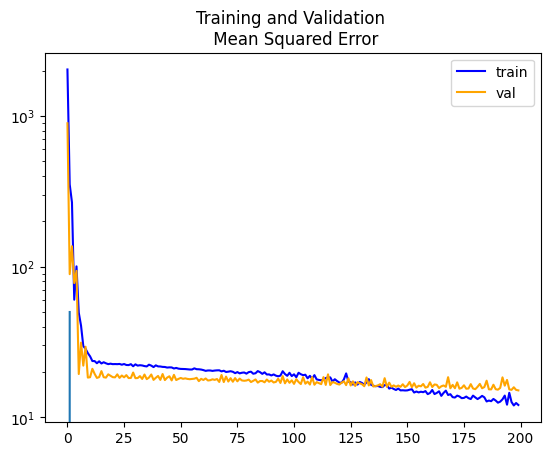

In [ ]:
# plt.figure()
# plt.title('Loss (Mean Squared Error)')
# plt.plot(history.history['loss'])
# plt.figure()
# plt.title('Accuracy')
# plt.plot(history.history['accuracy'])
# plt.figure()
# plt.title('Mean Squared Error')
# plt.plot(history.history['mean_squared_error'])
# plt.figure()
fig, ax = plt.subplots()
ax.set_title('Training and Validation \n Mean Squared Error') # loss = 100 * abs(y_true - y_pred) / y_true
ax.plot(history.history['loss'], color = 'blue', label = 'train')
# plt.figure()
## Validation Plots
# plt.title('Validation Loss (MSE)') # loss = 100 * abs(y_true - y_pred) / y_true
# plt.plot(history.history['val_loss'])
# plt.figure()

# plt.title('Validation Mean Absolute Percentage Error (MAPE)') # loss = 100 * abs(y_true - y_pred) / y_true
ax.plot(history.history['val_loss'], color = 'orange', label = 'val')
ax.semilogy((0,50))
ax.legend()
# plt.figure()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model
import numpy as np

y_pred = model.predict(X_test)

# 计算评估指标
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_2" is incompatible with the layer: expected shape=(None, 270, 16), found shape=(None, 8760, 19)
